# Trabalho Prático 3: Reconhecimento de Captcha



Carlos Ferreira dos Santos Junior, 2019054412

In [1]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D



from matplotlib import pyplot as plt
%matplotlib inline  

from pathlib import Path
import glob
import cv2

from keras import layers
from keras.models import Model
from keras.models import load_model

# Pré-processamento da entrada:

- Leitura dos dados de validação

In [2]:
val_path = glob.glob("./CAPTCHA-10k/validacao/*.jpg")
validacao = []
for img in val_path:
    n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    n = n / 255.0 
    n = np.reshape(n,(50,180,1))
    validacao.append(n)


print(np.shape(validacao))


(1000, 50, 180, 1)


- Leitura dos dados de teste

In [3]:
test_path = glob.glob("./CAPTCHA-10k/teste/*.jpg")
teste = []
for img in test_path:
    n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    n = n / 255.0
    n = np.reshape(n,(50,180,1))
    teste.append(n)


print(np.shape(teste))


(1000, 50, 180, 1)


- Leitura dos dados de treino

In [4]:
train_path = glob.glob("./CAPTCHA-10k/treinamento/*.jpg")
treinamento = []
for img in train_path:
    n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    n = n / 255.0
    n = np.reshape(n,(50,180,1))
    treinamento.append(n)


print(np.shape(treinamento))


(8000, 50, 180, 1)


- String contendo todos os 36 possíveis caracteres do captcha em ordem

In [5]:
caracter = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
len(caracter)

36

- Leitura dos dados de labels

In [6]:
labels_path = glob.glob("./CAPTCHA-10k/labels10k/*.txt")
labels = []
y = np.zeros((6,10000,36))
for file in labels_path:
    with open(file) as f:
        text = f.read()
        text = text.strip()
        labels.append(text)


print(len(labels))

10000


Com ajuda da string 'caracter', cada label é transformada em um np.array 6x36 onde cada um dos 6 caracteres está associado a um array que contém um "1.0" na posição lexicográfica que o caractere pertence e "0" nas 35 demais posições.

In [7]:
count = 0
for label in labels:
    target = np.zeros((6,36))
    for i in range(6):
        indice = caracter.find(label[i])
        target[i][indice] = 1.0
    y[:,count] = target
    count += 1
    
print(np.shape(y))

(6, 10000, 36)


- Separação e atribuição dos labels para cada grupo

In [8]:
labels_val = labels[8000:9000]
labels_teste = labels[9000:10000]
labels_treinamento = labels[0:8000]


In [9]:
y_val = y[:,8000:9000,:]
y_teste = y[:,9000:10000,:]
y_treinamento = y[:,0:8000,:]

print(np.shape(y_teste[0]))
print(np.shape(y_treinamento))

(1000, 36)
(6, 8000, 36)


# Modelagem da CNN:

- O modelo possui 3 camadas convolucionais alternadas com camadas de max-pooling 2x2 e uma batch normalization.
- Na parte não-convolucional existem 6 saídas diferentes ligadas à camada flat, cada uma com duas camadas e output no mesmo formato que a label detalhada anteriormente.

In [10]:
def createmodel():
    img = layers.Input(shape=(50,180,1)) # Camada de entrada 50x180x1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) 
    mp3 = layers.MaxPooling2D(padding='same')(bn)  
    
    flat = layers.Flatten()(mp3) 

    outs = []
    for _ in range(6): #Para os 6 caracteres do captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) 
        res = layers.Dense(36, activation='sigmoid', name='char'+ str(_))(drop)

        outs.append(res) #resultado 
    
    model = Model(inputs=img, outputs=outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [11]:
model=createmodel();
model.summary();

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 180, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 180, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 90, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 90, 32)   4640        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

# Treinamento e validação

- Após testar diversos valores, cheguei à conclusão de que 21 epochs leva a bons valores de acurácia e pouco overfitting 

In [13]:
hist = model.fit(np.array(treinamento),[y_treinamento[0], y_treinamento[1], y_treinamento[2], y_treinamento[3], y_treinamento[4], y_treinamento[5]], epochs = 21, batch_size = 50, validation_data=(np.array(validacao), [y_val[0], y_val[1], y_val[2], y_val[3], y_val[4], y_val[5]]))

Epoch 1/21
160/160 [==============================] - 17s 109ms/step - loss: 21.3382 - char0_loss: 3.5434 - char1_loss: 3.5314 - char2_loss: 3.5399 - char3_loss: 3.5558 - char4_loss: 3.5922 - char5_loss: 3.5756 - char0_accuracy: 0.0432 - char1_accuracy: 0.0454 - char2_accuracy: 0.0396 - char3_accuracy: 0.0405 - char4_accuracy: 0.0345 - char5_accuracy: 0.0318 - val_loss: 21.2666 - val_char0_loss: 3.5413 - val_char1_loss: 3.5280 - val_char2_loss: 3.5194 - val_char3_loss: 3.5359 - val_char4_loss: 3.5795 - val_char5_loss: 3.5625 - val_char0_accuracy: 0.0890 - val_char1_accuracy: 0.1010 - val_char2_accuracy: 0.0860 - val_char3_accuracy: 0.0760 - val_char4_accuracy: 0.0440 - val_char5_accuracy: 0.0340
Epoch 2/21
160/160 [==============================] - 17s 104ms/step - loss: 19.3093 - char0_loss: 3.1498 - char1_loss: 3.1458 - char2_loss: 3.1526 - char3_loss: 3.2236 - char4_loss: 3.3884 - char5_loss: 3.2491 - char0_accuracy: 0.0716 - char1_accuracy: 0.0996 - char2_accuracy: 0.1002 - char3_a

Epoch 13/21
160/160 [==============================] - 17s 107ms/step - loss: 2.9716 - char0_loss: 0.4072 - char1_loss: 0.5113 - char2_loss: 0.4669 - char3_loss: 0.4808 - char4_loss: 0.5541 - char5_loss: 0.5513 - char0_accuracy: 0.8528 - char1_accuracy: 0.8055 - char2_accuracy: 0.8223 - char3_accuracy: 0.8216 - char4_accuracy: 0.7933 - char5_accuracy: 0.8036 - val_loss: 1.1894 - val_char0_loss: 0.0999 - val_char1_loss: 0.1646 - val_char2_loss: 0.1827 - val_char3_loss: 0.1455 - val_char4_loss: 0.2304 - val_char5_loss: 0.3663 - val_char0_accuracy: 0.9710 - val_char1_accuracy: 0.9620 - val_char2_accuracy: 0.9590 - val_char3_accuracy: 0.9570 - val_char4_accuracy: 0.9310 - val_char5_accuracy: 0.8900
Epoch 14/21
160/160 [==============================] - 17s 105ms/step - loss: 2.7403 - char0_loss: 0.3731 - char1_loss: 0.4673 - char2_loss: 0.4429 - char3_loss: 0.4504 - char4_loss: 0.5057 - char5_loss: 0.5010 - char0_accuracy: 0.8629 - char1_accuracy: 0.8269 - char2_accuracy: 0.8378 - char3_ac

In [14]:
preds = model.evaluate(np.array(teste), [y_teste[0], y_teste[1], y_teste[2], y_teste[3], y_teste[4], y_teste[5]])

32/32 [==============================] - 1s 16ms/step - loss: 1.0239 - char0_loss: 0.0936 - char1_loss: 0.1235 - char2_loss: 0.1362 - char3_loss: 0.1457 - char4_loss: 0.2197 - char5_loss: 0.3052 - char0_accuracy: 0.9820 - char1_accuracy: 0.9690 - char2_accuracy: 0.9600 - char3_accuracy: 0.9700 - char4_accuracy: 0.9530 - char5_accuracy: 0.9280


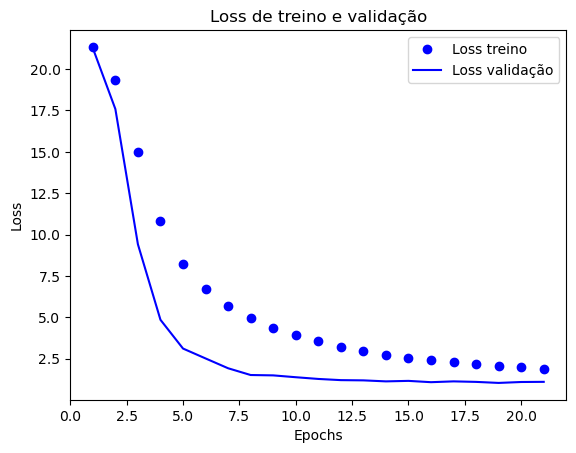

In [15]:
hist.history
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Loss treino')
plt.plot(epochs, val_loss_values, 'b', label='Loss validação')

plt.title('Loss de treino e validação')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.close()

- Preditor que gera uma string de predição do captcha 

In [16]:
def predict(img):

    
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis], verbose='0')) 

    result = np.reshape(res, (6, 36)) 
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adiciona o índice do char encontrado no captcha

    capt = '' #captcha predito
    for k in k_ind:
        capt += caracter[k] #caractere correspondente ao índice
    return capt 

## Conjunto de captchas do grupo de teste e seus respectivos captchas preditos


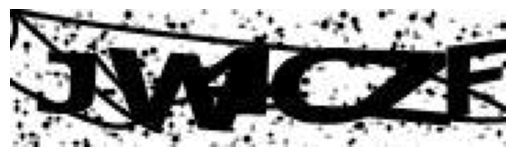

JW4CZF


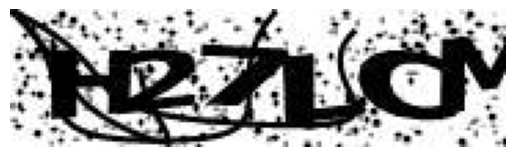

H27LCM


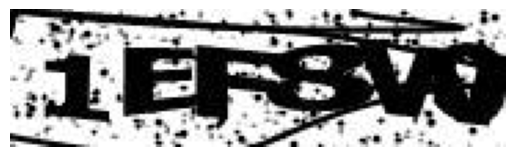

1EF8W0


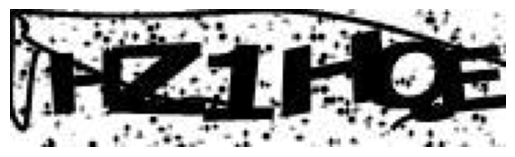

HZ1HQE


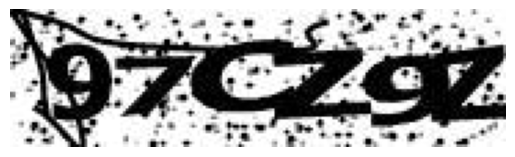

97CZ9Z


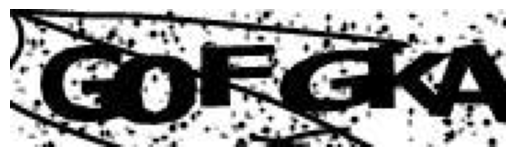

G0FGKA


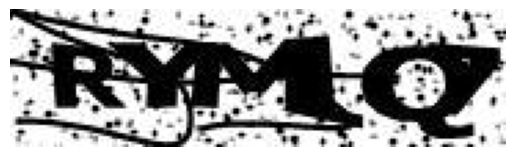

RYM1Q7


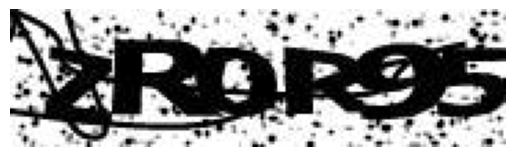

ZR0R95


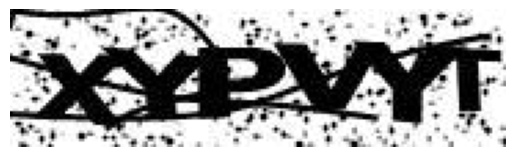

XYPVYT


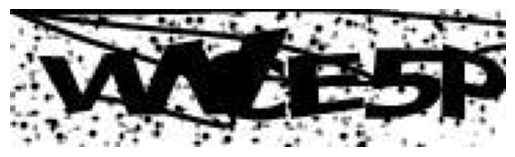

VW1E5P


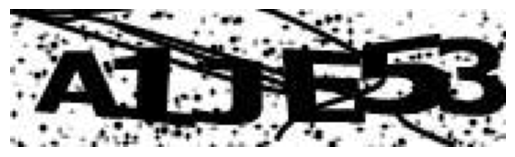

A1JE53


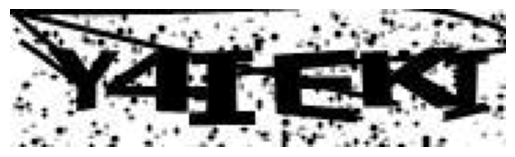

Y4IEKI


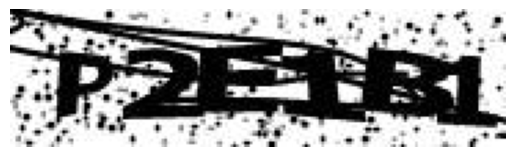

P2E1B1


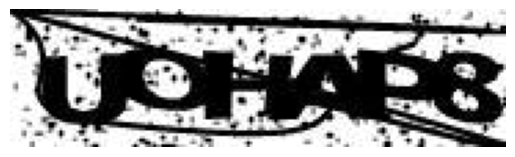

UOHAP8


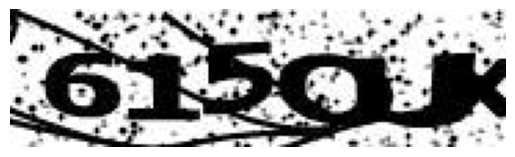

615OUK


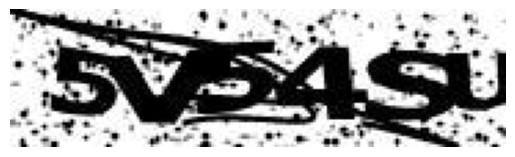

5V54SU


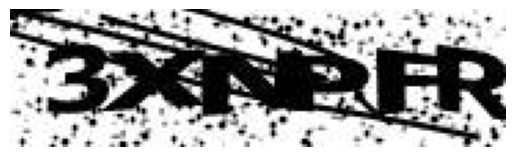

3XNPFR


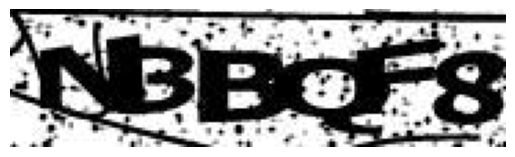

NBBQF8


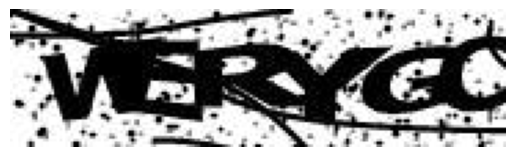

WERYGC


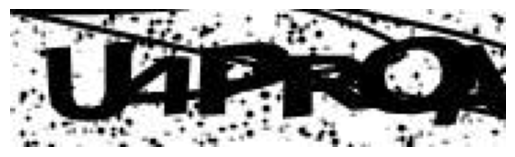

U4PROA


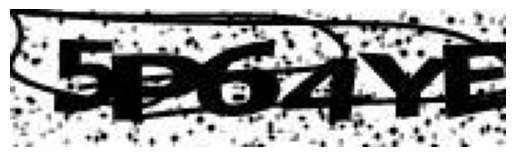

5P64YE


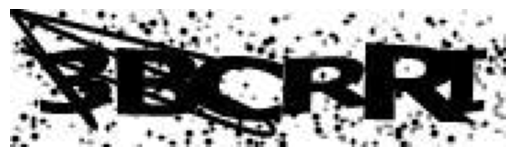

3BCRRI


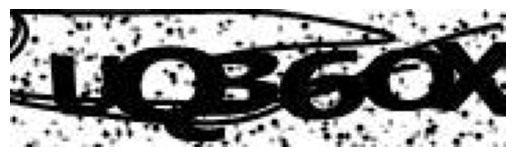

UQ36OX


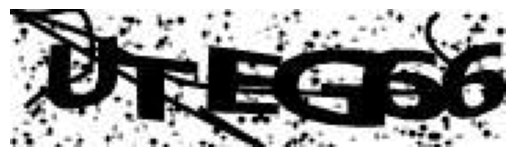

UTEG66


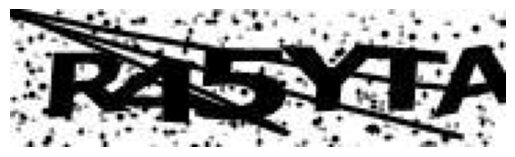

R45YTA


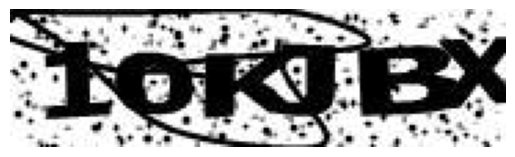

10KJBX


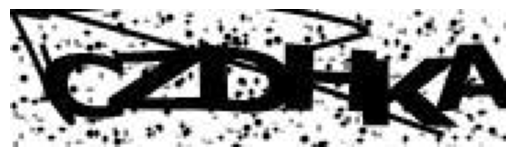

CZDHKA


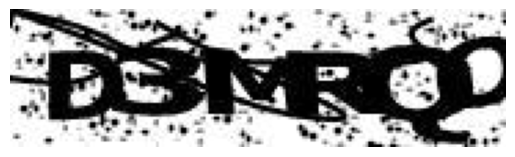

D3MRQO


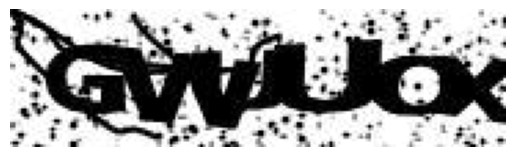

GWVUOX


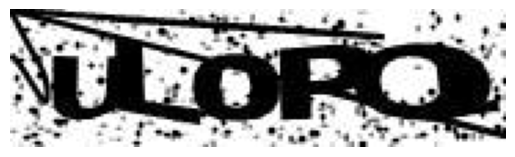

UL0PO1


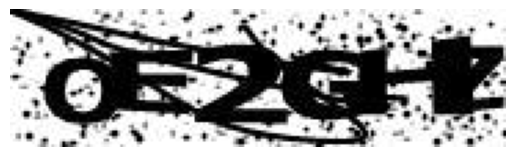

0E2GHZ


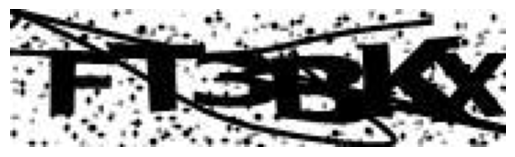

FT3BKX


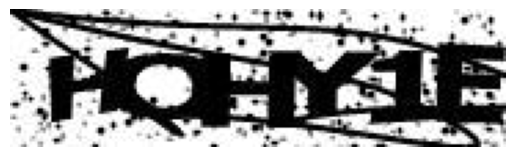

HOHY1E


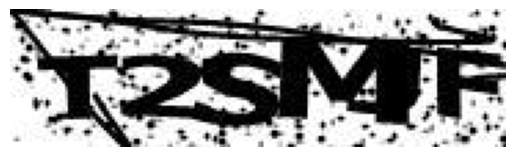

T2SMJF


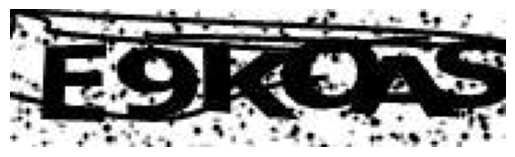

E9KOAS


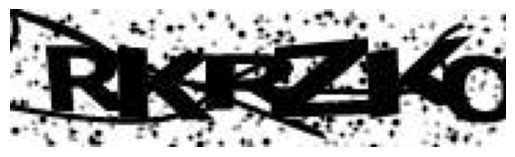

RKRZKO


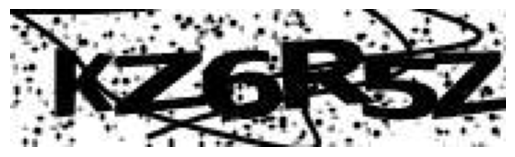

KZ6R5Z


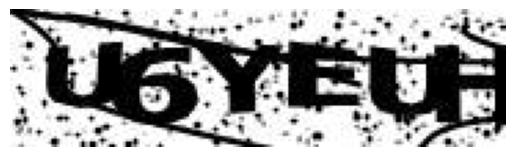

U6YEUH


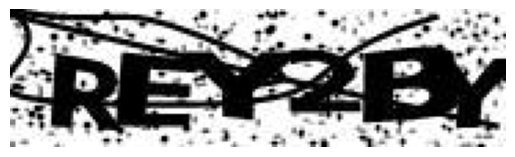

REY2BY


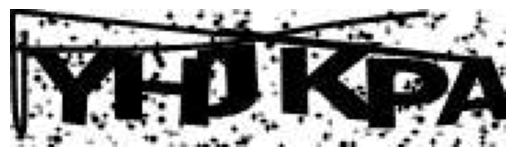

YHJKPA


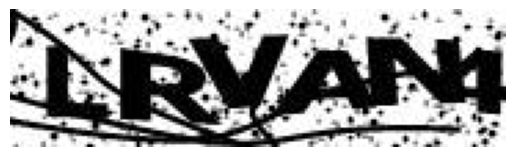

LRVAN4


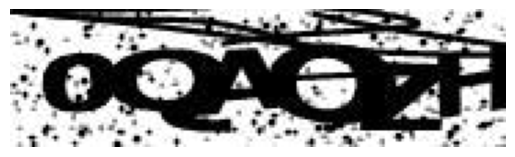

0QAOZH


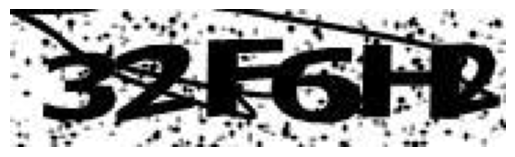

32F6H2


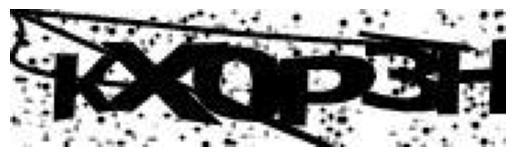

KX0P3H


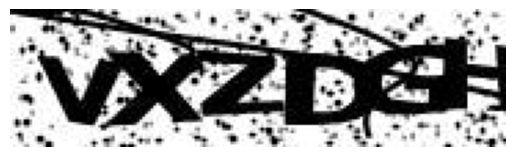

VXZDGH


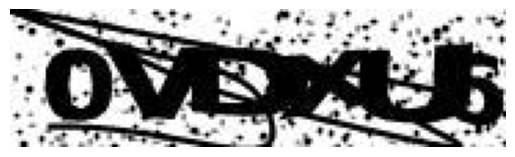

0VDXU6


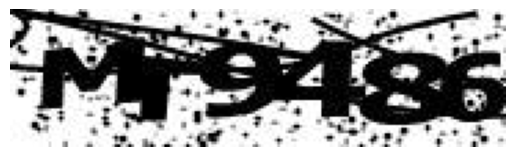

MT9486


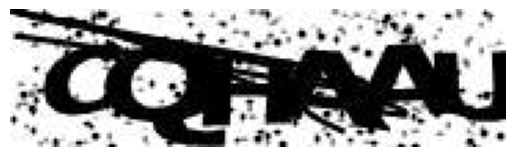

CQHAAU


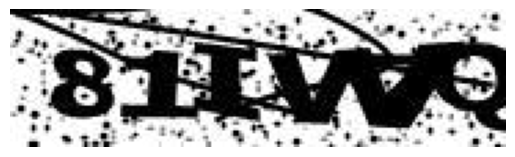

81IW7Q


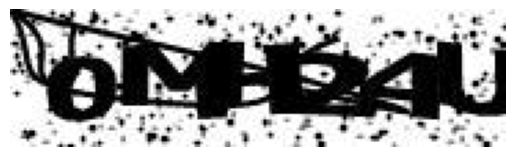

0MH24U


In [17]:
for i in range(0,50):
    plt.imshow(teste[i], cmap='gray')
    plt.axis('off')
    plt.show()
    print(predict(teste[i]))

- Taxa de acurácia do preditor no grupo de teste

In [18]:
correctPredictions = 0
wrongPredictions = 0
for i in range(0, len(labels_teste)):
    if predict(teste[i])==labels_teste[i]:
        correctPredictions+=1
    else:
        wrongPredictions+=1
print(f'Correct Predictions : {correctPredictions}\nWrong Predictions : {wrongPredictions}')
print(f'Accuracy : {correctPredictions*100/(correctPredictions+wrongPredictions)} %')

Correct Predictions : 785
Wrong Predictions : 215
Accuracy : 78.5 %


In [19]:
char_certos = []
for i in range(1000):
    predicao = []
    predicao = predict(teste[i])
    predicao
    certo = 0
    for j in range(6):
        if(labels_teste[i][j] == predicao[j]):
            certo += 1
    char_certos.append(certo)


In [20]:
seiscertos = [x for x in char_certos if x == 6]
cincocertos = [x for x in char_certos if x == 5]
quatrocertos = [x for x in char_certos if x == 4]
trescertos = [x for x in char_certos if x == 3]
doiscertos = [x for x in char_certos if x == 2]
umcertos = [x for x in char_certos if x == 1]
zerocertos = [x for x in char_certos if x == 0]
certos_6 = len(seiscertos)
certos_5 = len(cincocertos)
certos_4 = len(quatrocertos)
certos_3 = len(trescertos)
certos_2 = len(doiscertos)
certos_1 = len(umcertos)
certos_0 = len(zerocertos)

minimo1 = 1 - (certos_0)/1000
minimo2 = 1 - (certos_0 + certos_1)/1000
minimo3 = 1 - (certos_0 + certos_1 + certos_2)/1000
minimo4 = 1 - (certos_0 + certos_1 + certos_2 + certos_3)/1000
minimo5 = (certos_5 + certos_6)/1000
minimo6 = (certos_6)/1000


# Taxa de reconhecimento em função do número mínimo de caracteres que foram corretamente reconhecidos por captcha

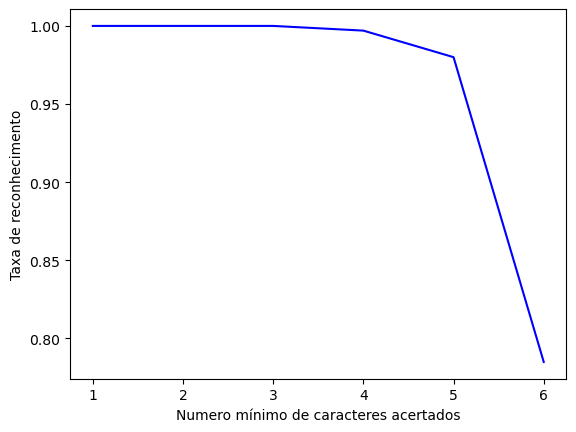

In [21]:
taxa_rec = [minimo1, minimo2, minimo3, minimo4, minimo5, minimo6]
a = [1,2,3,4,5,6]
plt.plot(range(1,7),taxa_rec, 'b')
plt.xlabel('Numero mínimo de caracteres acertados')
plt.ylabel('Taxa de reconhecimento')
plt.show()
